# Multimodal Report Generation (from a Slide Deck)

<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/multimodal/multimodal_report_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cookbook we show you how to build a multimodal report generator. The pipeline parses a slide deck and stores both text and image chunks. It generates a detailed response that contains interleaving text and images.

**NOTE**: This pipeline operates over the entire document and does not do retrieval, in order to retrieve the full context. You can of course explore adding a higher-level retrieval layer where you retrieve the relevant document(s) first before feeding to a multimodal model.

## Setup

In [ ]:
import nest_asyncio

nest_asyncio.apply()

### Setup Observability

We setup an integration with LlamaTrace (integration with Arize).

If you haven't already done so, make sure to create an account here: https://llamatrace.com/login. Then create an API key and put it in the `PHOENIX_API_KEY` variable below.

In [ ]:
!pip install -U llama-index-callbacks-arize-phoenix

In [ ]:
# setup Arize Phoenix for logging/observability
import llama_index.core
import os

PHOENIX_API_KEY = "<PHOENIX_API_KEY>"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

### Load Data

Here we load the [Conoco Phillips 2023 investor meeting slide deck](https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf).

In [ ]:
!mkdir data
!mkdir data_images
!wget "https://static.conocophillips.com/files/2023-conocophillips-aim-presentation.pdf" -O data/conocophillips.pdf

### Model Setup

Setup models that will be used for downstream orchestration.

In [ ]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding(model="text-embedding-3-large")
llm = OpenAI(model="gpt-4o")

Settings.embed_model = embed_model
Settings.llm = llm

## Use LlamaParse to Parse Text and Images

In this example, use LlamaParse to parse both the text and images from the document, using our multimodal mode (+ Sonnet 3.5).

This returns both the parsed document using Sonnet, but also the rendered image chunks saved locally.

In [ ]:
from llama_parse import LlamaParse

parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    vendor_multimodal_model_name="anthropic-sonnet-3.5",
)

In [ ]:
print(f"Parsing slide deck...")
md_json_objs = parser.get_json_result("data/conocophillips.pdf")
md_json_list = md_json_objs[0]["pages"]

Parsing PDF file...
Started parsing the file under job_id 412ac275-abe2-4585-be43-5680e7754740


In [ ]:
print(md_json_list[10]["md"])

# Commitment to Disciplined Reinvestment Rate

Disciplined Reinvestment Rate is the Foundation for Superior Returns on and of Capital, while Driving Durable CFO Growth

| Metric | Value |
|--------|-------|
| 10-Year Reinvestment Rate | ~50% |
| CFO CAGR 2024-2032 | ~6% |
| Mid-Cycle Planning Price | at $60/BBL WTI |

| Period | Industry Growth Focus | ConocoPhillips Strategy Reset | Reinvestment Rate |
|--------|------------------------|-------------------------------|-------------------|
| 2012-2016 | >100% Reinvestment Rate | - | ~$75/BBL WTI Average |
| 2017-2022 | - | <60% Reinvestment Rate | ~$63/BBL WTI Average |
| 2023E | - | - | at $80/BBL WTI |
| 2024-2028 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |
| 2029-2032 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |

*Chart shows ConocoPhillips Average Annual Reinvestment Rate (%) over time, with historic rates in grey and projected rates in blue.*

Reinvestment rate and cash from operations (CFO) are non-GA

In [ ]:
print(md_json_list[1].keys())

dict_keys(['page', 'md', 'images', 'items'])


In [ ]:
image_dicts = parser.get_images(md_json_objs, download_path="data_images")

## Setup and Build Index

In this section we create a set of nodes from the slide deck, one per page, and attach the corresponding rendered image file path as metadata for each parsed page chunk. 

We then build a simple summary index over the saved deck. **NOTE**: We could do vector indexing too, but here we want to produce comprehensive reports which oftentimes require access to the entire document.

#### Get Text Nodes

In [ ]:
from llama_index.core.schema import TextNode
from typing import Optional

In [ ]:
# get pages loaded through llamaparse
import re


def get_page_number(file_name):
    match = re.search(r"-page-(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0


def _get_sorted_image_files(image_dir):
    """Get image files sorted by page."""
    raw_files = [f for f in list(Path(image_dir).iterdir()) if f.is_file()]
    sorted_files = sorted(raw_files, key=get_page_number)
    return sorted_files

In [ ]:
from copy import deepcopy
from pathlib import Path


# attach image metadata to the text nodes
def get_text_nodes(json_dicts, image_dir=None):
    """Split docs into nodes, by separator."""
    nodes = []

    image_files = _get_sorted_image_files(image_dir) if image_dir is not None else None
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        chunk_metadata = {"page_num": idx + 1}
        if image_files is not None:
            image_file = image_files[idx]
            chunk_metadata["image_path"] = str(image_file)
        chunk_metadata["parsed_text_markdown"] = md_text
        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes

In [ ]:
# this will split into pages
text_nodes = get_text_nodes(md_json_list, image_dir="data_images")

In [ ]:
print(text_nodes[10].get_content(metadata_mode="all"))

page_num: 11
image_path: data_images/412ac275-abe2-4585-be43-5680e7754740-page-10.jpg
parsed_text_markdown: # Commitment to Disciplined Reinvestment Rate

Disciplined Reinvestment Rate is the Foundation for Superior Returns on and of Capital, while Driving Durable CFO Growth

| Metric | Value |
|--------|-------|
| 10-Year Reinvestment Rate | ~50% |
| CFO CAGR 2024-2032 | ~6% |
| Mid-Cycle Planning Price | at $60/BBL WTI |

| Period | Industry Growth Focus | ConocoPhillips Strategy Reset | Reinvestment Rate |
|--------|------------------------|-------------------------------|-------------------|
| 2012-2016 | >100% Reinvestment Rate | - | ~$75/BBL WTI Average |
| 2017-2022 | - | <60% Reinvestment Rate | ~$63/BBL WTI Average |
| 2023E | - | - | at $80/BBL WTI |
| 2024-2028 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |
| 2029-2032 | - | - | at $60/BBL WTI (with $80/BBL WTI option shown) |

*Chart shows ConocoPhillips Average Annual Reinvestment Rate (%) over time, with histo

In [ ]:
import os
from llama_index.core import (
    StorageContext,
    SummaryIndex,
    load_index_from_storage,
)

if not os.path.exists("storage_nodes_summary"):
    index = SummaryIndex(text_nodes)
    # save index to disk
    index.set_index_id("summary_index")
    index.storage_context.persist("./storage_nodes_summary")
else:
    # rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="storage_nodes_summary")
    # load index
    index = load_index_from_storage(storage_context, index_id="summary_index")

## Build Query Engine

We now use LlamaIndex abstractions to build a **structured query engine**. In contrast to a standard RAG query engine which just outputs plain text, here we define a structured output schema (`ReportOutput`), and attach it to the LLM. By using this structured LLM, the RAG query engine will output a structured output.

In [ ]:
from llama_index.llms.openai import OpenAI
from pydantic.v1 import BaseModel, Field
from typing import List
from IPython.display import display, Markdown, Image


class TextBlock(BaseModel):
    """Text block."""

    text: str = Field(..., description="The text for this block.")


class ImageBlock(BaseModel):
    """Image block."""

    file_path: str = Field(..., description="File path to the image.")


class ReportOutput(BaseModel):
    """Data model for a report.

    Can contain a mix of text and image blocks. MUST contain at least one image block.

    """

    blocks: List[TextBlock | ImageBlock] = Field(
        ..., description="A list of text and image blocks."
    )

    def render(self) -> None:
        """Render as HTML on the page."""
        for b in self.blocks:
            if isinstance(b, TextBlock):
                display(Markdown(b.text))
            else:
                display(Image(filename=b.file_path))


system_prompt = """\
You are a report generation assistant tasked with producing a well-formatted context given parsed context.

You will be given context from one or more reports that take the form of parsed text.

You are responsible for producing a report with interleaving text and images - in the format of interleaving text and "image" blocks.
Since you cannot directly produce an image, the image block takes in a file path - you should write in the file path of the image instead.

How do you know which image to generate? Each context chunk will contain metadata including an image render of the source chunk, given as a file path. 
Include ONLY the images from the chunks that have heavy visual elements (you can get a hint of this if the parsed text contains a lot of tables).
You MUST include at least one image block in the output.

You MUST output your response as a tool call in order to adhere to the required output format. Do NOT give back normal text.

"""


llm = OpenAI(model="gpt-4o", system_prompt=system_prompt)
sllm = llm.as_structured_llm(output_cls=ReportOutput)

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=10,
    llm=sllm,
    # response_mode="tree_summarize"
    response_mode="compact",
)

In [ ]:
response = query_engine.query(
    "Give me a summary of the financial performance of the Alaska/International segment vs. the lower 48 segment"
)

The financial performance of ConocoPhillips' Alaska/International segment and the Lower 48 segment can be summarized as follows:

### Alaska/International Segment

- **Capital Expenditures**: Expected to average $3.7 billion in 2023, $4.4 billion from 2024-2028, and $3.0 billion from 2029-2032.
- **Production**: Projected to be around 750 MBOED in 2023, increasing to 870 MBOED on average from 2024-2028, and reaching 1080 MBOED on average from 2029-2032.
- **Free Cash Flow (FCF)**: Estimated at $5.5 billion in 2023, averaging $6.5 billion from 2024-2028, and $15.0 billion from 2029-2032.
- **Key Projects**: Includes significant investments in LNG, Surmont, Montney, and conventional international assets.

### Lower 48 Segment

- **Capital Expenditures**: Expected to be $6.3 billion in 2023, averaging $6.5 billion from 2024-2028, and $8.1 billion from 2029-2032.
- **Production**: Projected to be around 1050 MBOED in 2023, increasing to 1220 MBOED on average from 2024-2028, and reaching 1530 MBOED on average from 2029-2032.
- **Free Cash Flow (FCF)**: Estimated at $7 billion in 2023, averaging $5.5 billion from 2024-2028, and $8 billion from 2029-2032.
- **Key Projects**: Focused on the Permian Basin, Eagle Ford, and Bakken, with significant investments in technology and emissions reductions.

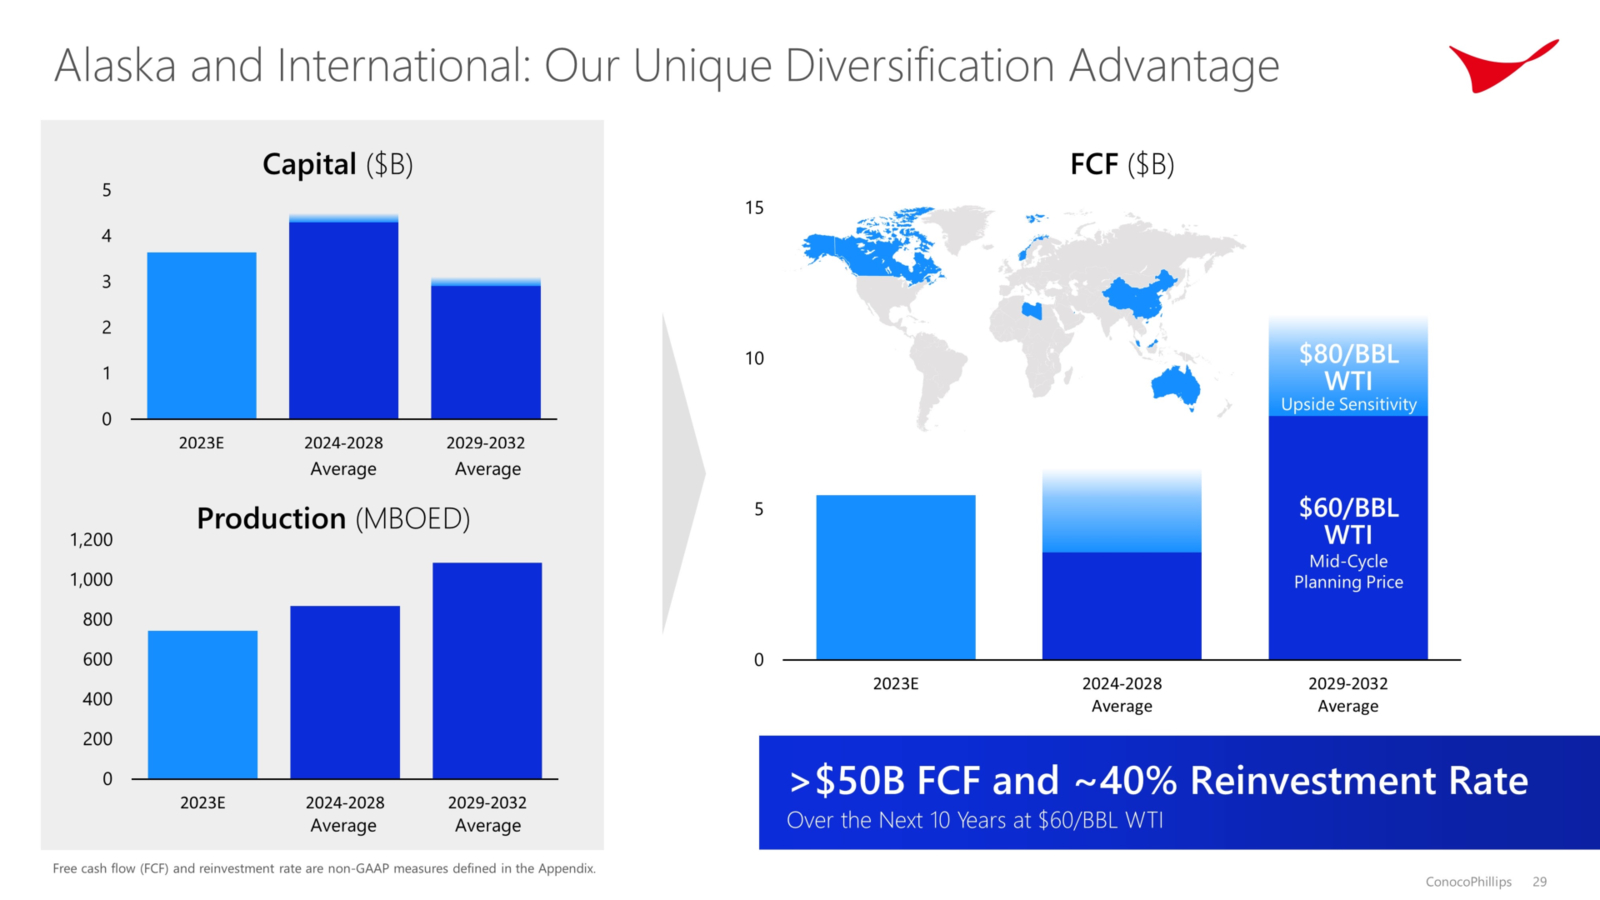

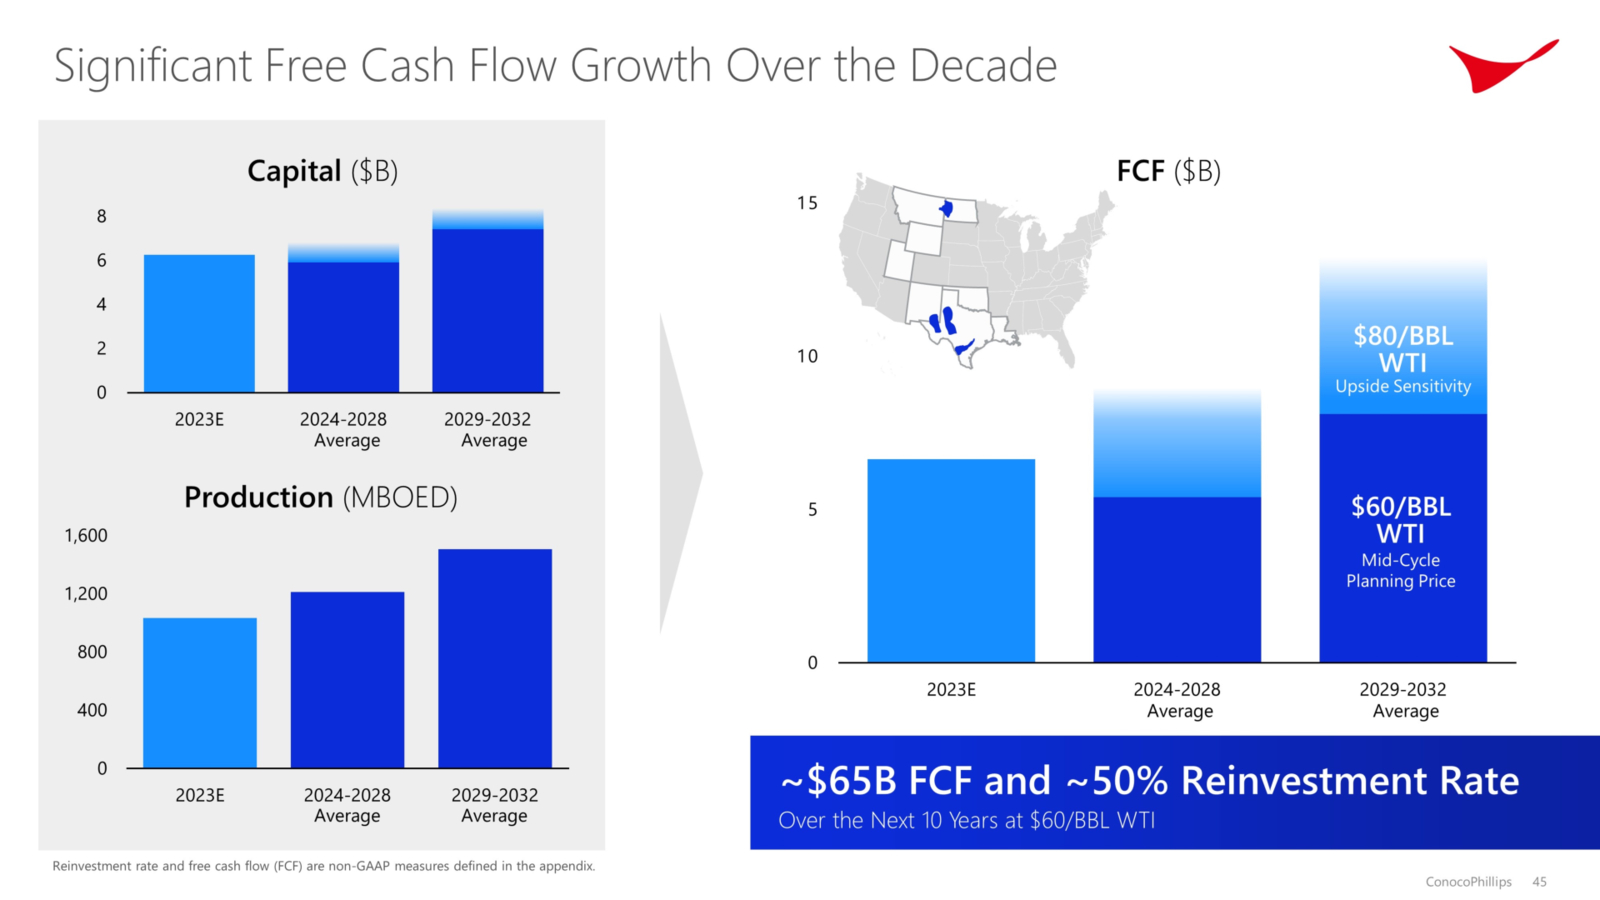

In [ ]:
response.response.render()

In [ ]:
response = query_engine.query(
    "Give me a summary of whether you think the financial projections are stable, and if not, what are the potential risk factors. "
    "Support your research with sources."
)

The financial projections for ConocoPhillips appear stable based on several key indicators and strategic plans outlined in their 2023 Analyst & Investor Meeting presentation.

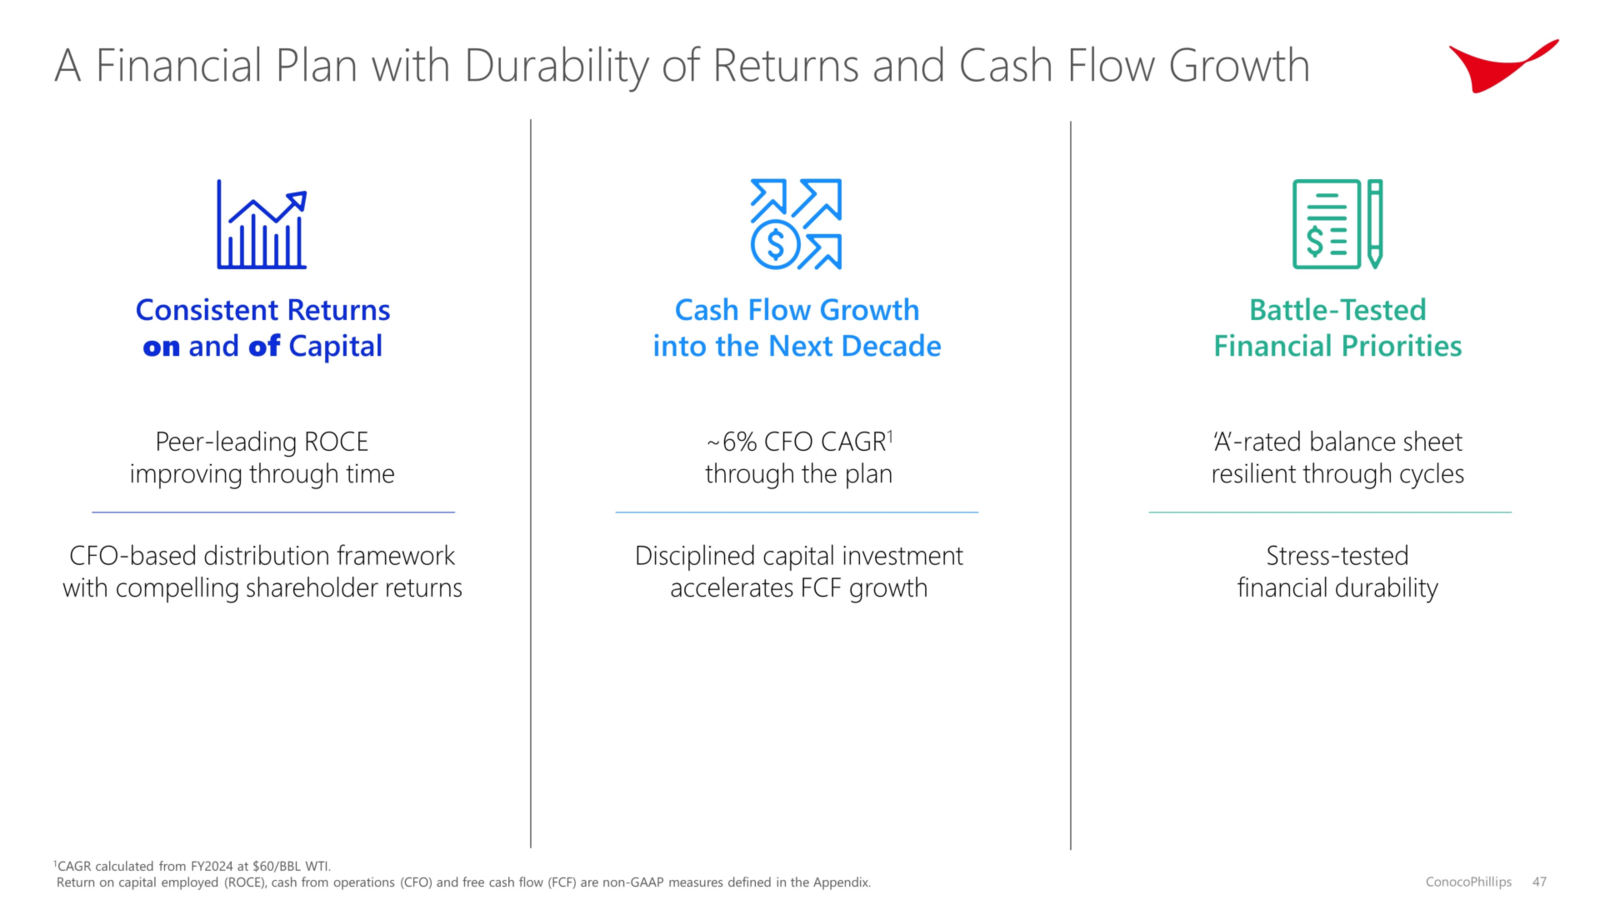

**Key Indicators of Stability: **

1. **Consistent Returns on and of Capital:** The company has a strong track record of delivering returns on capital employed (ROCE) and has set a goal to maintain peer-leading ROCE performance. The five-year average ROCE for ConocoPhillips is 14%, which is higher than many of its peers.

2. **Cash Flow Growth:** ConocoPhillips projects a compound annual growth rate (CAGR) of ~6% for cash from operations (CFO) and ~11% for free cash flow (FCF) from 2024 to 2032 at a $60/BBL WTI price. This indicates a robust growth trajectory for cash flow.

3. **Strong Balance Sheet:** The company aims to reduce its debt by $5 billion by 2026, which will result in an annual interest reduction of approximately $250 million. The net debt to CFO ratio is projected to be 0.3x on average from 2024 to 2028, indicating a strong balance sheet.

4. **Distribution Commitment:** ConocoPhillips has committed to returning 30% of CFO to shareholders through dividends and share buybacks, which demonstrates a focus on shareholder returns.

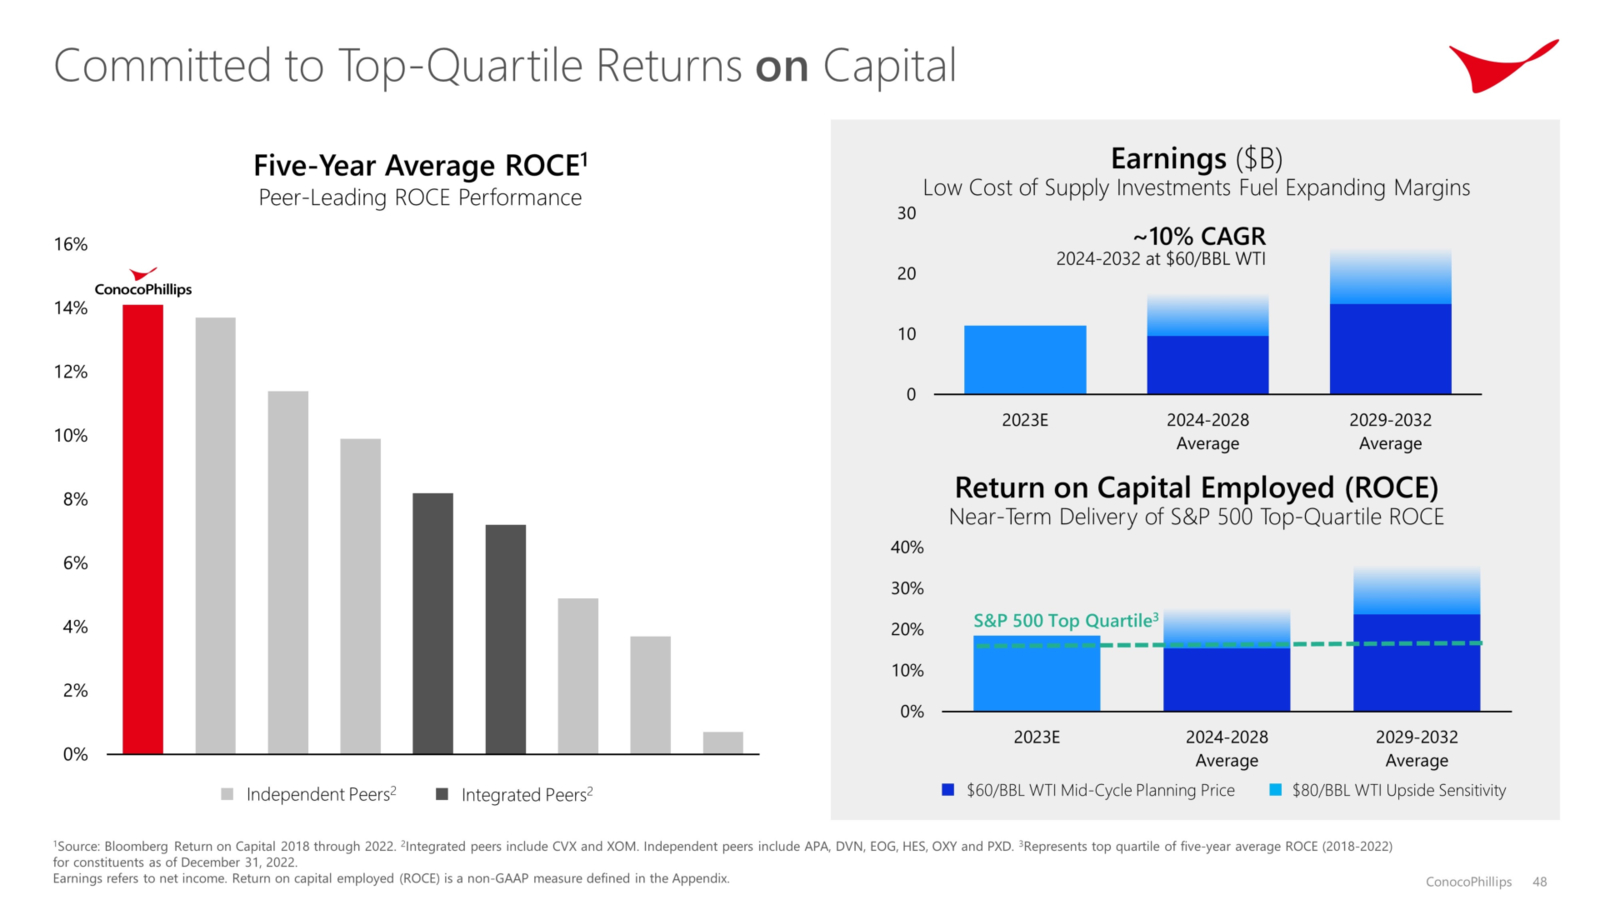

**Potential Risk Factors: **

1. **Commodity Price Volatility:** The financial projections are based on certain price assumptions for oil and gas. Any significant deviation from these price assumptions could impact the company's cash flow and profitability. For example, a prolonged decline in oil prices could reduce cash from operations and free cash flow.

2. **Regulatory and Environmental Risks:** Changes in environmental regulations or the imposition of new carbon taxes could increase operating costs and impact profitability. The company's commitment to reducing greenhouse gas emissions and achieving net-zero emissions by 2050 also involves significant investments and operational changes.

3. **Operational Risks:** Potential failures or delays in achieving expected production levels from existing and future developments could impact financial performance. This includes risks related to drilling, technical difficulties, and unexpected cost increases.

4. **Geopolitical Risks:** Global and regional changes, such as military conflicts, trade restrictions, and political instability, could affect the demand, supply, and prices of oil and gas. The ongoing conflict between Russia and Ukraine is an example of a geopolitical risk that could impact the company's operations and financial performance.

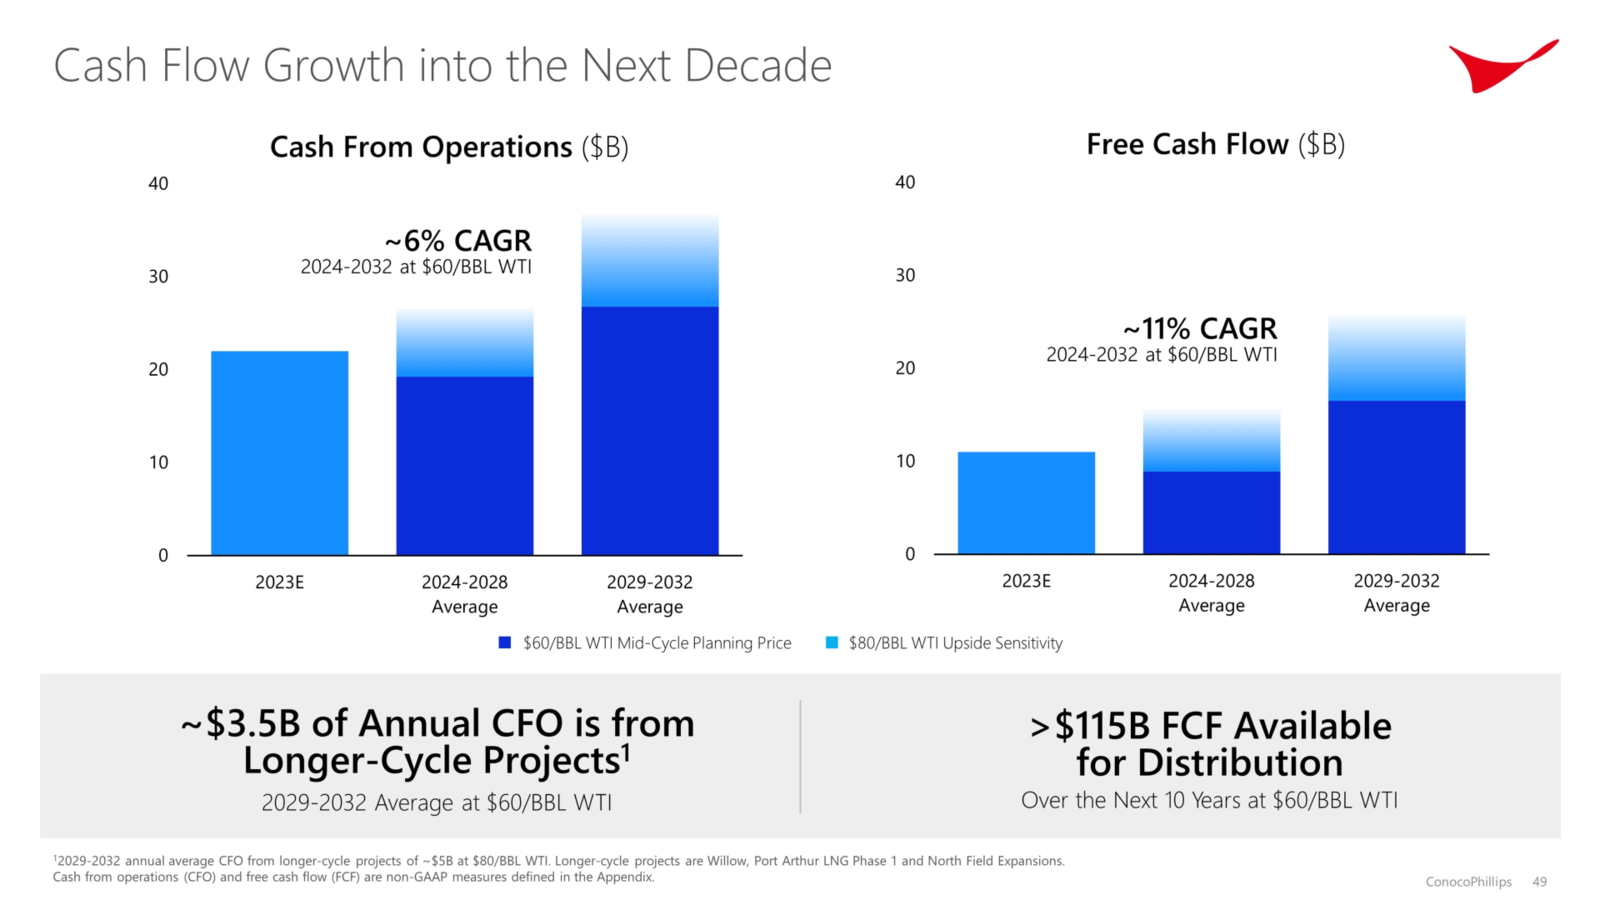

In conclusion, while ConocoPhillips' financial projections appear stable and are supported by a strong balance sheet, consistent returns, and robust cash flow growth, there are several potential risk factors that could impact these projections. Commodity price volatility, regulatory and environmental risks, operational challenges, and geopolitical uncertainties are key factors that need to be monitored.

In [ ]:
response.response.render()